In [1]:
import os
import pywt
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from src.models.simple import SimpleCNN

import yaml
import pickle
import importlib
from types import SimpleNamespace
from quantus.metrics import Complexity

from physioex.physioex.data import PhysioExDataModule
from physioex.physioex.train.models.load import load_model

from src.utils import split_string
from src.attribution import compute_attribution
from src.evaluation.evaluation import evaluate_attributions


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)                          # Python built-in random
    np.random.seed(seed)                       # NumPy random
    torch.manual_seed(seed)                    # CPU random seed
    torch.cuda.manual_seed(seed)               # GPU random seed (if used)
    torch.cuda.manual_seed_all(seed)           # All GPUs (if multiple GPUs)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# set seed
set_seed(42)

# to mps if available otherwise to cpu
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
print(f"Using device: {device}")

# # load the model
# model = SimpleCNN(in_channels=1, out_channels=2, hidden_size=64, kernel_size=5)

# # load the model weights
# model.load_state_dict(torch.load("./model/checkpoint/simpleCNN_2.pth", map_location=torch.device('mps')))
# model.to(device)

Using device: mps


In [4]:
# set_seed(42)

# # Load and shape synthetic test data
# x = None
# y = None

# # load the data from synthetic data
# data_folder = "./data/synthetic/test_2"
# data_files = os.listdir(data_folder)
# for file in data_files:
#     if "samples_0_0" in file:
#         if x is None and y is None:
#             x = np.load(os.path.join(data_folder, file))
#             y = np.zeros(5000)
#         else:
#             x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
#             y = np.concatenate([y, np.zeros(5000)])
#     elif "samples_1_0" in file:
#         if x is None and y is None:
#             x = np.load(os.path.join(data_folder, file))
#             y = np.ones(5000)
#         else:
#             x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
#             y = np.concatenate([y, np.ones(5000)])
#     else:
#         print("File not recognized")
#         continue
    

# x = x[:, np.newaxis, :]

# print(x.shape)
# print(y.shape)

# # convert the data to torch tensors
# x = torch.tensor(x, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.long)

# # Shuffle indices once
# indices = torch.randperm(len(x))

# # Apply the shuffle
# x_shuffled = x[indices]
# y_shuffled = y[indices]

# # create the dataset
# dataset = TensorDataset(x_shuffled, y_shuffled)

# # create the DataLoader
# test_loader = DataLoader(dataset, batch_size=128)


In [ ]:
target_package = "physioex.train.networks.utils.target_transform"
target_class = "get_mid_label"
target = getattr(importlib.import_module(target_package), target_class)

set_seed(42)

datamodule = PhysioExDataModule(
    datasets=["sleepedf"],     # list of datasets to be used
    batch_size=128,            # batch size for the DataLoader
    preprocessing="raw",       # preprocessing method
    selected_channels=["EEG"], # channels to be selected
    sequence_length=7,         # length of the sequence
    target_transform= target,  # since seq to epoch, target seq
    num_workers = 8,          # number of parallel workers
    data_folder = "data"    # path to the data folder
)

In [6]:
# get the test DataLoaders
test_loader = datamodule.test_dataloader()

print(len(test_loader)) # number of batches in the test set

206


In [ ]:
attributions = {}
attributions['deletion'] = {}
attributions['insertion'] = {}
predictions = []
labels = []

# prediction
for batch in test_loader:
    # get data
    x, y = batch
    x = x.to(device)
    y = y.to(device)

    # print(x.shape)
    # print(y.shape)
    output = model(x)

    predictions.append(output)
    labels.append(y)

# concatenat the predictions and the labels through the first dim
predictions = torch.cat(predictions, dim=0)
labels = torch.cat(labels, dim=0)

torch.Size([128, 7, 1, 3000])
torch.Size([128])


In [ ]:
# save it in the attributions dict
attributions['predictions'] = predictions
attributions['labels'] = labels

In [8]:
# evaluate wavelet
fs = 100
T = 30
data_len = T * fs
batch_size = 128
wavelet = 'coif'
w_len = 5
level = 5
key_ = f'wavelet_{wavelet}{w_len}_{level}_{batch_size}'
print(key_)

wavelet_coif5_5_128


In [9]:
# plot scaleograms

def plot_dwt_scaleogram(coeffs, w='db1', fs=16, t=1, label=0):
    """
    coeffs: list of coefficients
    fs: sampling frequency
    """
    # Create a figure
    plt.figure(figsize=(10, 6))

    # compute the frequency bands
    freq_bands = [fs / (2 ** (j + 1)) for j in range(len(coeffs[0]))]   # bands
    freq_bands.append(0)                                             # lowest frequency
    freq_bands = freq_bands[::-1]                                    # reverse the order

    print(len(freq_bands))
    
    scaleogram = np.array(coeffs)
    # scaleogram = scaleogram[:, :]
    scaleogram = np.abs(scaleogram)
    
    # normalize the scaleogram
    scaleogram = (scaleogram - np.min(scaleogram)) / (np.max(scaleogram) - np.min(scaleogram) + 1e-10)

    # Create a meshgrid for time and frequency
    time = np.linspace(0, t, fs * t )
    time = np.concatenate([time, [time[-1] + (1/(fs*t))]])

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, freq_bands, scaleogram.T, shading='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(f'Scaleogram of class {label} of wavelet {w}')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')

    plt.tight_layout()
    plt.show()

In [10]:
def apply_dwt_filterbank_(data, fs, wavelet):
        """
        Apply the wavelet filterbank to the data.

        Parameters
        ----------
        data : np.ndarray or torch.Tensor
            Input data to be transformed. If a torch tensor is provided, it will be converted to numpy.
        """
        if isinstance(data, torch.Tensor):
            data = data.detach().cpu().numpy()
        else:
            data = data
        time = np.linspace(0, len(data) / fs, len(data))

        coeffs = pywt.wavedec(data, wavelet)

        return coeffs, time

In [13]:
number_of_batches = 206
num_iterarions = number_of_batches // 4
print(num_iterarions)

51


In [43]:
attributions = {}
attributions['deletion'] = {}
attributions['insertion'] = {}
predictions = []
labels = []

In [21]:
import torch
import numpy as np
from src.attribution.wavelet.wavelet import WaveletFilterbank
from src.utils.sampling import downsample_wavedec, upsampling_wavedec

class WaveletMask:
    def __init__(self, model, wavelet_filterbank: WaveletFilterbank, regularization='l1', device='cpu'):
        self.model = model.to(device)
        self.filterbank = wavelet_filterbank
        self.device = device
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.regularization = regularization
        self.nbanks = 5

    def fit(self,
            data,
            n_epoch: int = 250,
            learning_rate: float = 1.0e-2,
            keep_ratio: float = 0.01,
            reg_factor_init: float = 1.0,
            reg_factor_dilation: float = 1.0,
            stopping: float = 1.0e-5,
            patience: int = 10,
            verbose: bool = True,
            normalize: bool = False,
            rescale: bool = False,
            use_only_max: bool = True):
        
        self.model.eval()
        early_stopping_counter = 0

        if len(data.shape) == 3:
            # sequence_length = data.shape[0]
            # print("Here")
            # data = data[3]
            data = data.unsqueeze(0)
        data = data.float().to(self.device)

        # Get model target
        with torch.no_grad():
            target = self.model(data)
            target = torch.nn.functional.softmax(target, dim=1)
            if use_only_max:
                target = torch.argmax(target, dim=1)

        

        # Initialize mask
        
        mask_shape = torch.tensor(data.shape)
        mask = (0.1 * torch.ones((*mask_shape, self.nbanks), device=self.device)).detach()
        mask.requires_grad_()

        # print(f"Mask init: {mask}")

        optimizer = torch.optim.Adam([mask], lr=learning_rate)

        # Regularization
        if self.regularization == 'ratio':
            reg_ref = torch.zeros(int((1 - keep_ratio) * self.nbanks))
            reg_ref = torch.cat((reg_ref, torch.ones(self.nbanks - reg_ref.shape[0]))).to(self.device)

        # Get filtered bands from wavelet filterbank
        # print(f"bands now")
        # bands = upsampling_wavedec(16, coeffs)
        # plot_dwt_scaleogram(bands.T, 'db1', 16)

        # print(f"bands shape: {bands.shape}")

        bands = self.filterbank.get_wavelet_bands()
        bands = torch.tensor(bands).float().to(self.device) # (n_channels, time, n_filters)
        bands = bands.permute(-1, -2)
        bands = bands.unsqueeze(0)
        # print(f"bands reshaped: {bands.shape}")
        # plot_dwt_scaleogram(bands.squeeze().detach().cpu().numpy(), 'db1', 16)
        # print(f"Bands: {bands}")

        reg_strength = reg_factor_init
        reg_multiplicator = np.exp(np.log(reg_factor_dilation) / max(n_epoch, 1))
        # print(f"Reg strength: {reg_strength}")
        # print(f"Reg multiplicator: {reg_multiplicator}")

        prev_loss = float('inf')
        total_loss = []

        for epoch in range(n_epoch):
            optimizer.zero_grad()
            # Apply mask and sum
            masked = (bands * mask).sum(-1)
            # # plot the mask
            # plt.plot(mask.squeeze().detach().cpu().numpy())
            # plt.title("Mask")
            # plt.show()

            # # print(f"Bands")
            # # plot_dwt_scaleogram(bands.squeeze().detach().cpu().numpy(), 'db1', 16)

            # print(f"Masked")
            # plot_dwt_scaleogram(masked.squeeze().detach().cpu().numpy(), 'db1', 16)

            # masked = masked.sum(-1)
            # # masked = bands * mask
            # plt.plot(masked.squeeze().detach().cpu().numpy())
            # plt.title("Masked")
            # plt.show()



            # # move last axis to the first
            # masked = masked.squeeze()
            # masked = masked.permute(1, 0)
            # downsample = downsample_wavedec(len(masked[0]), masked.detach().cpu().numpy(), self.filterbank.wavelet, 1)
            # s = pywt.waverec(downsample, self.filterbank.wavelet)
            # # make it a torch tensor
            # masked = torch.tensor(s).float().to(self.device)
            # plt.plot(s)
            # plt.title("Masked signal")
            # plt.show()
            
            # masked = masked.unsqueeze(0)


            
            # print(f"Masked: {masked}")
            output = self.model(masked)
            # print(f"Output: {output}")
            output = torch.nn.functional.softmax(output, dim=1)
            # print(f"Output softmax: {output}")
            target_loss = self.loss_fn(output, target)

            # Compute regularization
            if self.regularization == 'l1':
                reg_loss = torch.max(mask.abs().mean() - keep_ratio, torch.tensor(0., device=self.device))
            elif self.regularization == 'l2':
                reg_loss = mask.pow(2).mean()
            elif self.regularization == 'ratio':
                reg_loss = ((torch.sort(mask)[0] - reg_ref)**2).mean()
            else:
                reg_loss = 0.0

            loss = target_loss + reg_strength * reg_loss
            loss.backward()
            optimizer.step()

            # Clamp mask to [0, 1]
            mask.data = torch.clamp(mask, 0, 1)
            total_loss.append(loss.item())

            reg_strength *= reg_multiplicator

            if verbose and epoch % 10 == 0:
                print(f'Epoch {epoch}: Loss={loss.item():.4f}, Target={target_loss.item():.4f}, Reg={reg_loss.item():.4f}')

            # Early stopping
            if abs(prev_loss - total_loss[-1]) < stopping:
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0
            prev_loss = total_loss[-1]
            if early_stopping_counter > patience:
                break

        return mask, total_loss



In [ ]:
import torch
import numpy as np
from src.utils.sampling import upsampling_wavedec


def compute_wavelet_attribution( model, 
                                 dataloader, 
                                 filterbank_params = {'wavelet': 'db', 'w_len': 1, 'fs': 16, 'level': 4}, 
                                 device:str = 'cpu', 
                                 verbose:bool = True,
                                 normalize:bool = False,
                                 regularization:str = 'l1'):
    # define mask
    masks = []
    scores = []
    losses = []

    # create filterbank
    filterbank = WaveletFilterbank(**filterbank_params)

    # create FLEXtime mask
    mask_opt = WaveletMask(model, filterbank, device=device, regularization=regularization) 

    for i, batch in enumerate(dataloader):
        batch_scores = []
        filter_batch_scores = []

        # compute the batch scores
        print(f"Batch {i} of {len(dataloader)}")

        for j, (x, y) in enumerate(zip(*batch)):
            print(f"Sample {j} of {len(batch[0])}")

            x = x.to(device)
            y = y.to(device)

            # computing the wavelet transform for the target sequence
            if len(x.shape) == 3:
                sequence_length = x.shape[1]
                signal = x[sequence_length //2][0] # assuming one channel
            else: 
                signal = x[0]

            # plt.plot(signal.detach().cpu().numpy())
            # plt.title("Signal")
            # plt.show()

            # test = pywt.wavedec(signal.detach().cpu().numpy(), 'db1')
            # upsampled = upsampling_wavedec(16, test)
            # plot_dwt_scaleogram(upsampled.T, 'db1', 16)

            # create filterbank assuming 1 channel
            filterbank.apply_dwt_filterbank(signal)
            # coeffs, time = apply_dwt_filterbank_(signal, fs, 'db1')
            
            # get the attribution mask
            mask, loss = mask_opt.fit(x, verbose=verbose)
            # print(type(mask))

            losses.append(loss)
            mask = mask.squeeze().cpu().detach().numpy() # shape (time, n_filters)
            # print(f"Mask shape: {mask.shape}")

            # normalize 
            imp = torch.tensor(filterbank.get_filter_response(mask)) # shape (channels, time, n_filters)
            # print(f"Imp shape: {imp.shape}")

            batch_scores.append(imp)
            filter_batch_scores.append(mask)

        # store the data
        masks.append(torch.stack(batch_scores)) # shape (batch_len, channels, time, n_filters)
        scores.append(np.stack(filter_batch_scores))  # shape (batch_len, time, n_filters)

        if i == num_iterarions:
            break

    return masks, scores, losses, y

In [23]:
# load the model
with open("./config.yaml", "r") as file:
        config = yaml.safe_load(file)

network_config = config["model_config"]

# load the model class
model_package, model_class = config["model"].split(":")
model_class = getattr(importlib.import_module(model_package), model_class)

# casting the float types
network_config['learning_rate'] = float(network_config['learning_rate'])
network_config['weight_decay'] = float(network_config['weight_decay'])
network_config['adam_beta_1'] = float(network_config['adam_beta_1'])
network_config['adam_beta_2'] = float(network_config['adam_beta_2'])
network_config['adam_epsilon'] = float(network_config['adam_epsilon'])

model_path = "./model/checkpoint/fold=-1-epoch=19-step=19898-val_acc=0.83.ckpt"
model = load_model(
    model = model_class,
    model_kwargs = network_config,
    ckpt_path = model_path
)

print(f"Model loaded successfully {model}")



1
Model loaded successfully Chambon2018Net(
  (nn): Net(
    (epoch_encoder): SleepStagerChambon2018(
      (feature_extractor): Sequential(
        (0): Conv2d(1, 8, kernel_size=(1, np.int64(50)), stride=(1, 1), padding=(0, np.int64(25)))
        (1): Identity()
        (2): ReLU()
        (3): MaxPool2d(kernel_size=(1, np.int64(13)), stride=(1, np.int64(13)), padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(8, 8, kernel_size=(1, np.int64(50)), stride=(1, 1), padding=(0, np.int64(25)))
        (5): Identity()
        (6): ReLU()
        (7): MaxPool2d(kernel_size=(1, np.int64(13)), stride=(1, np.int64(13)), padding=0, dilation=1, ceil_mode=False)
      )
    )
    (clf): Linear(in_features=952, out_features=5, bias=True)
    (drop): Dropout(p=0.5, inplace=False)
  )
  (wacc): MulticlassAccuracy()
  (macc): MulticlassAccuracy()
  (wf1): MulticlassF1Score()
  (mf1): MulticlassF1Score()
  (ck): MulticlassCohenKappa()
  (pr): MulticlassPrecision()
  (rc): MulticlassRecall()
  (

In [24]:
set_seed(42)

masks, scores, losses, y = compute_wavelet_attribution(model, test_loader, device = device)

Batch 0 of 206
Sample 0 of 128
Epoch 0: Loss=1.5350, Target=1.4450, Reg=0.0900
Epoch 10: Loss=0.9618, Target=0.9051, Reg=0.0567
Epoch 20: Loss=0.9430, Target=0.9049, Reg=0.0381
Epoch 30: Loss=0.9329, Target=0.9049, Reg=0.0281
Epoch 40: Loss=0.9262, Target=0.9049, Reg=0.0214
Epoch 50: Loss=0.9214, Target=0.9049, Reg=0.0165
Epoch 60: Loss=0.9177, Target=0.9049, Reg=0.0128
Epoch 70: Loss=0.9148, Target=0.9049, Reg=0.0100
Epoch 80: Loss=0.9125, Target=0.9049, Reg=0.0077
Epoch 90: Loss=0.9107, Target=0.9049, Reg=0.0058
Epoch 100: Loss=0.9091, Target=0.9049, Reg=0.0042
Epoch 110: Loss=0.9078, Target=0.9049, Reg=0.0030
Epoch 120: Loss=0.9067, Target=0.9049, Reg=0.0018
Epoch 130: Loss=0.9058, Target=0.9049, Reg=0.0009
Epoch 140: Loss=0.9050, Target=0.9049, Reg=0.0001
Epoch 150: Loss=0.9049, Target=0.9049, Reg=0.0000
Sample 1 of 128
Epoch 0: Loss=1.7182, Target=1.6282, Reg=0.0900
Epoch 10: Loss=0.9653, Target=0.9050, Reg=0.0602
Epoch 20: Loss=0.9489, Target=0.9049, Reg=0.0440
Epoch 30: Loss=0.9

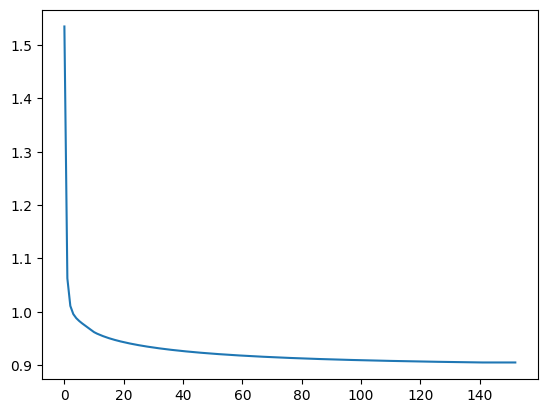

In [25]:
# plot the loss of the first sample
plt.plot(losses[0])
plt.show()


In [26]:
def plot_fft(signal, fs):
    N = len(signal)
    T = 1 / fs
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, T)[:N//2]
    
    plt.figure(figsize=(10, 6))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.title("FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

In [27]:
small_test = x.detach().cpu().numpy().transpose(1, 2, 0, 3)[3][0].flatten()
len(small_test)

384000

3000
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])


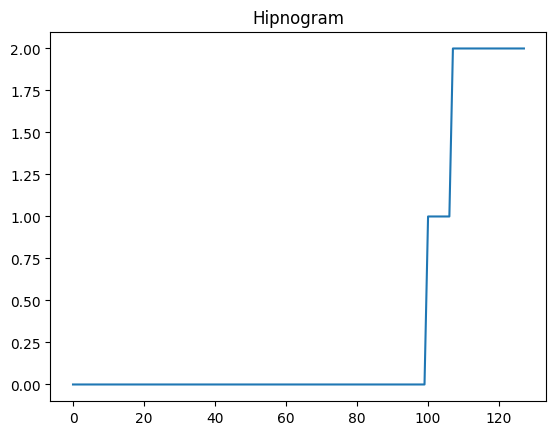

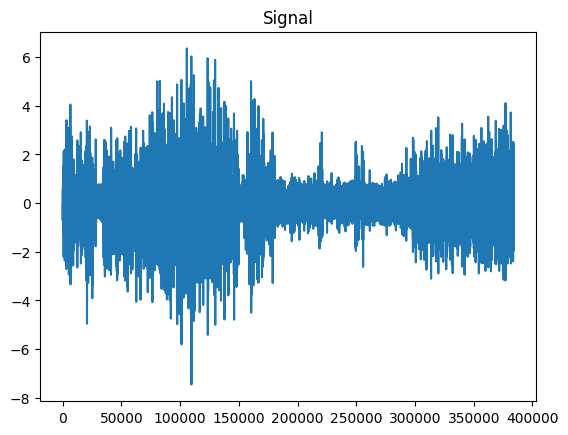

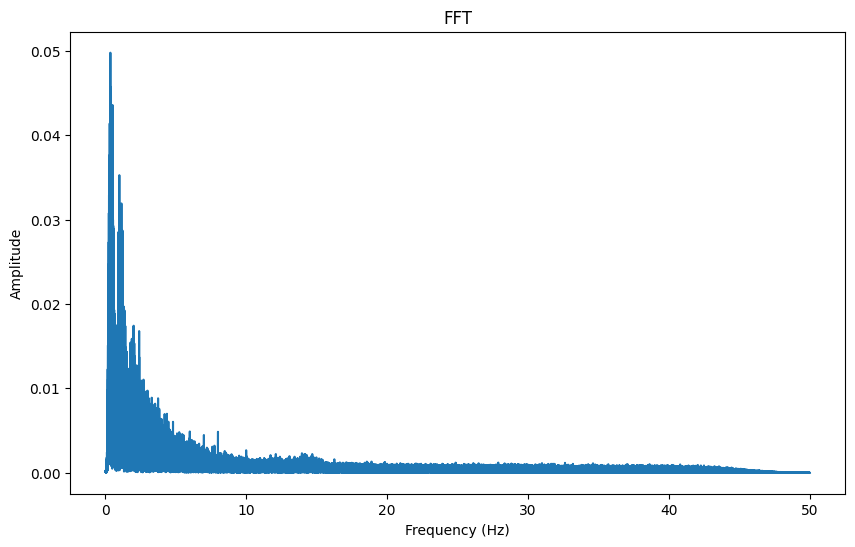

6
7


<Figure size 1000x600 with 0 Axes>

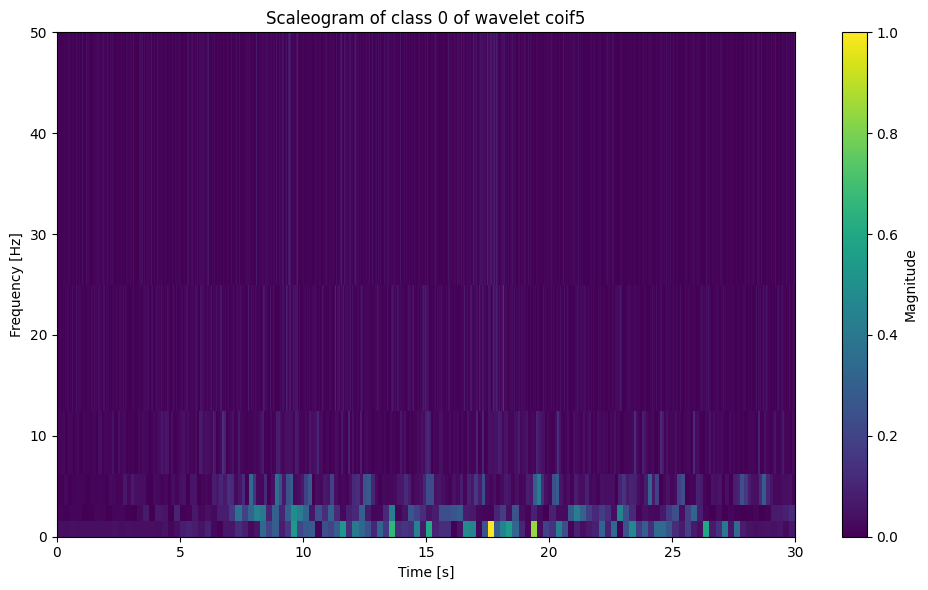

In [41]:


signal = x[0][3][0]
print(len(signal))
print(y)

# plot the hipnogram
plt.figure()
plt.plot(y)
plt.title("Hipnogram")
plt.show()

# plot the signal
plt.figure()
plt.plot(small_test)
plt.title("Signal")
plt.show()

# plot fft
plot_fft(small_test, 100)

coeffs = pywt.wavedec(signal, 'coif5', level=5)
coeffs = upsampling_wavedec(len(signal), coeffs)
print(len(coeffs))
plot_dwt_scaleogram(coeffs.T, fs=100, t=30, w='coif5', label=0)

6
7


<Figure size 1000x600 with 0 Axes>

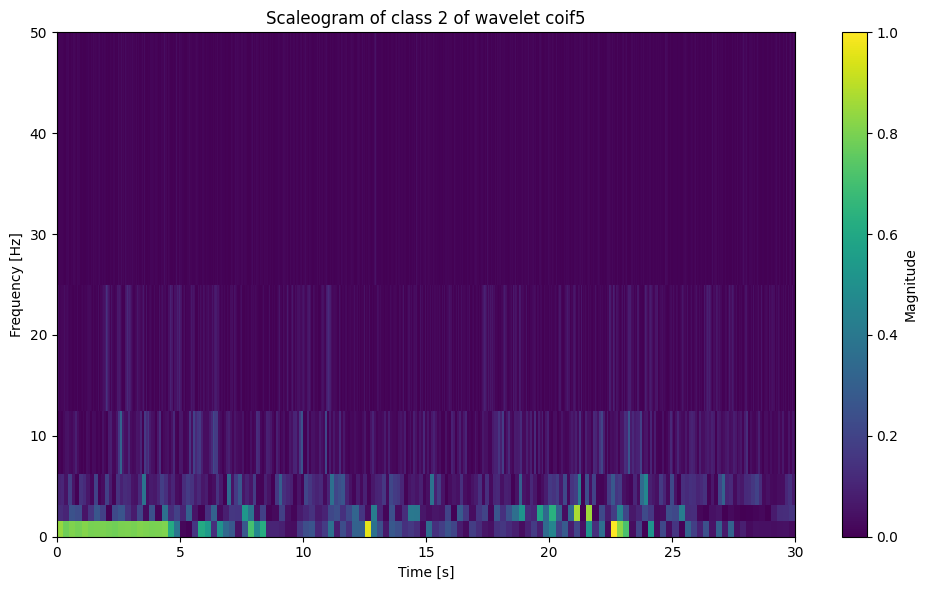

In [42]:
signal_2 = x[120][3][0]

coeffs = pywt.wavedec(signal_2, 'coif5', level=5)
coeffs = upsampling_wavedec(len(signal_2), coeffs)
print(len(coeffs))
plot_dwt_scaleogram(coeffs.T, fs=100, t=30, w='coif5', label=2)

In [36]:
def plot_scaleogram_wav_heatmap(signal, attribution, prediction:int, label:int, fs=1000 ):
    # print(attribution.shape)

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(len(attribution[0]))]   # bands
    freq_bands.append(0)                                        # lowest frequency
    freq_bands = freq_bands[::-1]                               # reverse the order
    # print(freq_bands)

    time = np.linspace(0, signal / fs, signal)
    

    # normalize attribution scores to [0,1]
    attribution = np.abs(attribution)
    attr_norm = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq_bands)
    # make attr x one dim smaller
    attr_norm = attr_norm[1:,:]

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_norm.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.title(f'Attributions of class {label} learned through wavelet coif5')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

In [30]:
print(len(scores))
print(len(scores[0]))
print(len(scores[0][0]))
print(len(scores[0][0][0]))


52
128
7
3000


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


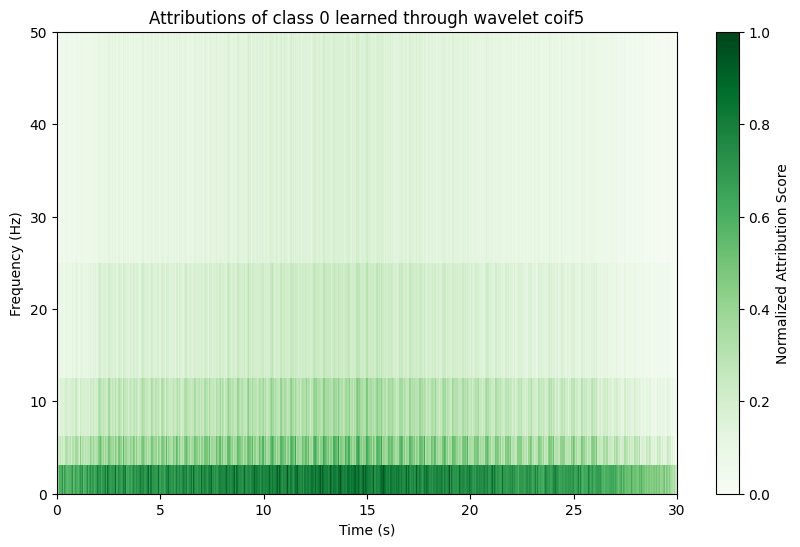

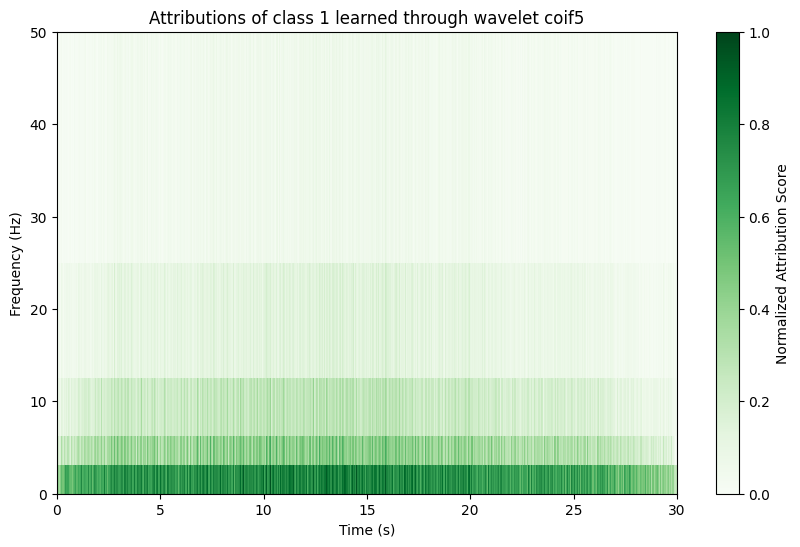

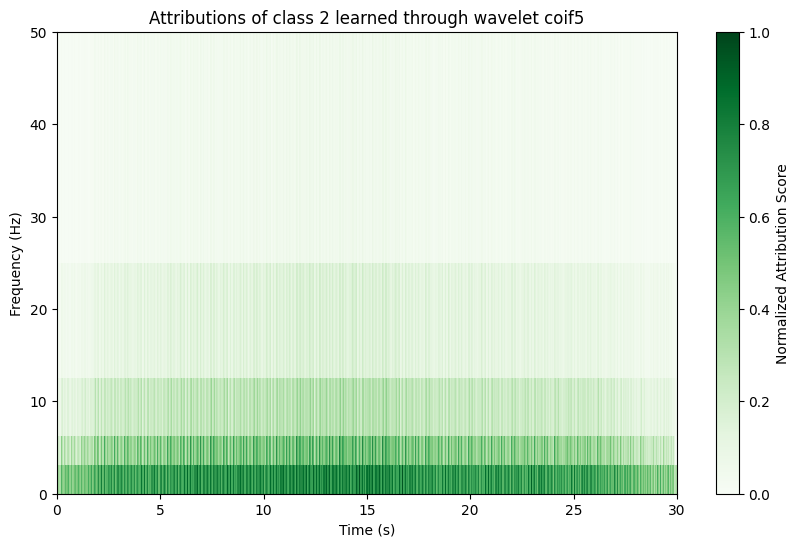

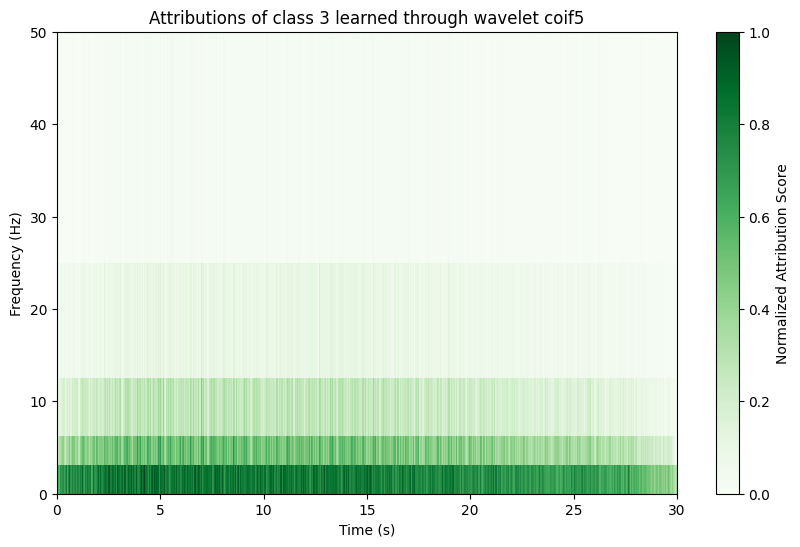

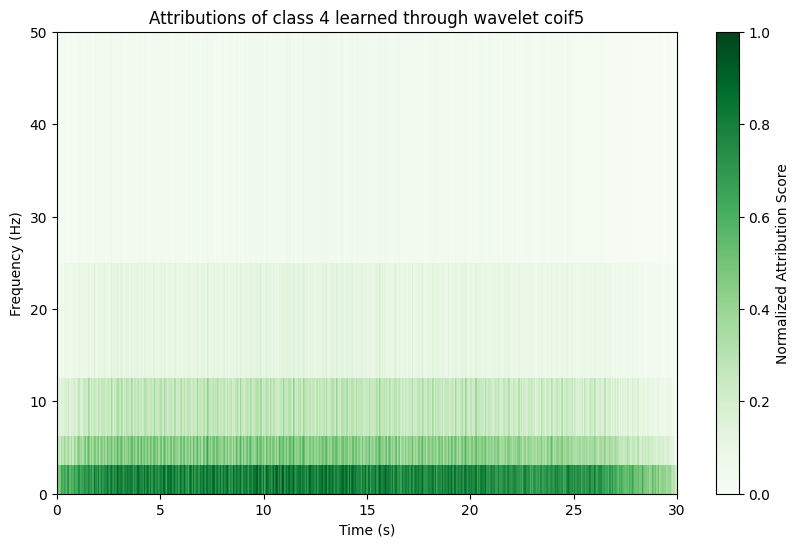

In [37]:
# "Sleep stage W": 0,
# "Sleep stage 1": 1,
# "Sleep stage 2": 2,

counts_0 = 0
counts_1 = 0
counts_2 = 0
counts_3 = 0
counts_4 = 0

data_length = 3000
fs = 100

# attributions['insertion']['wavelet_db1_4_128'] = scores

set_seed(42)

# for key in attributions['insertion'].keys():
#     print(key)

# method, wavelet, max_level, batch_size = key.split('_')
# max_level = int(max_level)

masks_0 = np.zeros_like(scores[0][0][0])
masks_1 = np.zeros_like(scores[0][0][0])
masks_2 = np.zeros_like(scores[0][0][0])
masks_3 = np.zeros_like(scores[0][0][0])
masks_4 = np.zeros_like(scores[0][0][0])

index = 0

for i, batch in enumerate(test_loader):
    x, y = batch

    for j in range(len(scores[i])):
        # print(index)
        if y[j] == 0:
            counts_0 += 1
            masks_0 += scores[i][j][3]
        elif y[j] == 1:
            counts_1 += 1
            masks_1 += scores[i][j][3]
        elif y[j] == 2:
            counts_2 += 1
            masks_2 += scores[i][j][3]
        elif y[j] == 3:
            counts_3 += 1
            masks_3 += scores[i][j][3]
        elif y[j] == 4:
            counts_4 += 1
            masks_4 += scores[i][j][3]

        index += 1
        print(index)

    if i == 51:
        break

masks_0 /= counts_0
masks_1 /= counts_1
masks_2 /= counts_2
masks_3 /= counts_3
masks_4 /= counts_4

print(f"Counts of label 0: {counts_0}, label 1: {counts_1}, label 2: {counts_2}, label 3: {counts_3}, label 4: {counts_4}")
print(f"Shape of mask 0: {masks_0.shape}, mask 1: {masks_1.shape}, mask 2: {masks_2.shape}, mask 3: {masks_3.shape}, mask 4: {masks_4.shape}")

plot_scaleogram_wav_heatmap(data_length, masks_0, prediction=0, label=0, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_1, prediction=1, label=1, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_2, prediction=2, label=2, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_3, prediction=3, label=3, fs=fs)
plot_scaleogram_wav_heatmap(data_length, masks_4, prediction=4, label=4, fs=fs)

    

In [45]:
attributions[key_] = masks
attributions[f'filtermasks_{key_}'] = scores

print(len(attributions[key_]))
print(len(attributions[f'filtermasks_{key_}']))


52
52


In [46]:
# save the results in a pkl file
folder = 'public/sleepedf/'
path = f'{folder}{key_}.pkl'

with open(path, 'wb') as f:
    pickle.dump(attributions, f)
print(f"Saved to {path}")

Saved to public/sleepedf/wavelet_coif5_5_128.pkl


Counts of label 0: 5000, label 1: 5000
1
1
2
4
8


<Figure size 1000x600 with 0 Axes>

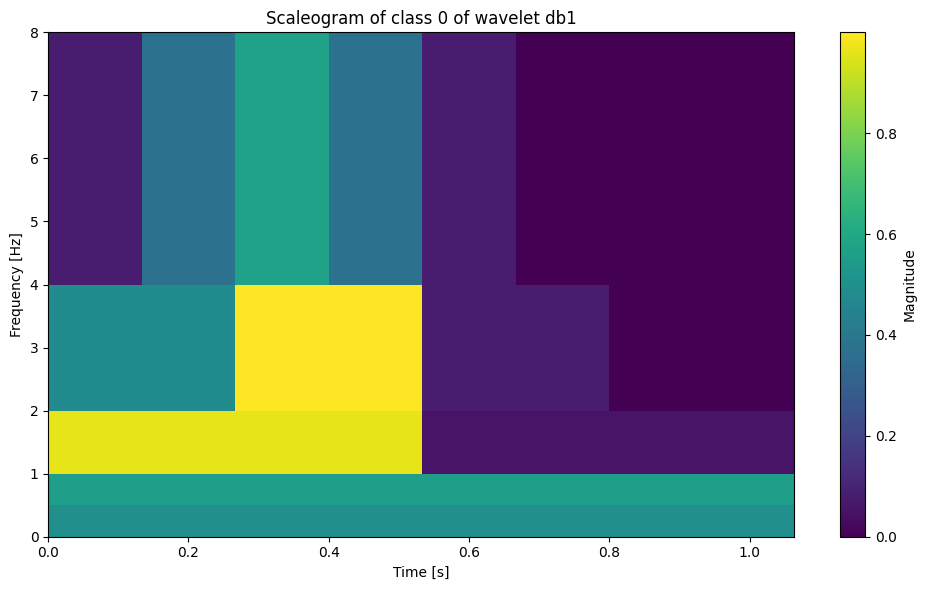

<Figure size 1000x600 with 0 Axes>

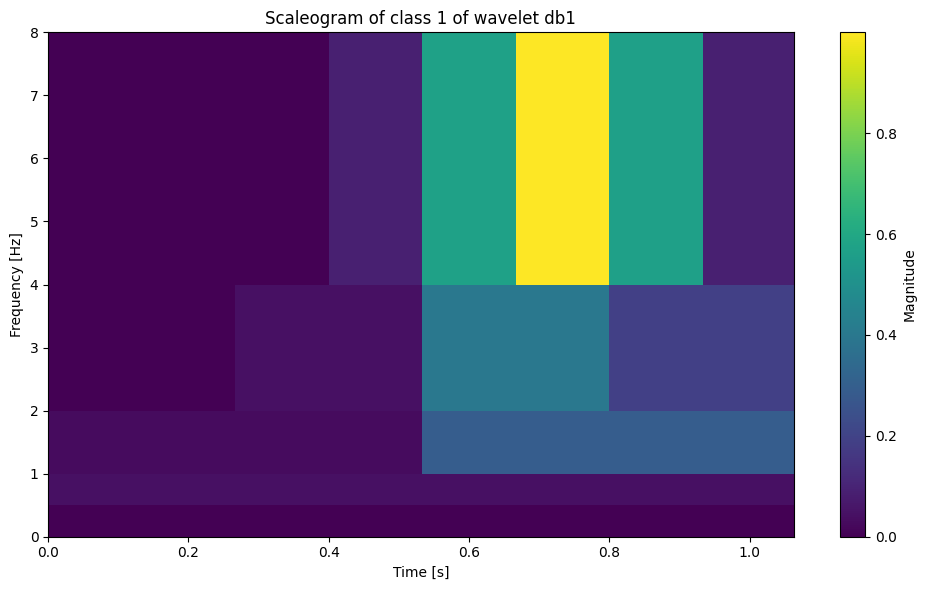

In [24]:
from src.utils.sampling import upsampling_wavedec

counts_0 = 0
counts_1 = 0

wavelets_0 = np.zeros((5, 16))
wavelets_1 = np.zeros((5, 16))

for batch in test_loader:
    x, y = batch
    
    for i, channels in enumerate(x):
        signal = channels[0].detach().cpu().numpy()

        coeffs = pywt.wavedec(signal, 'db1', level=4)
        upsampled = upsampling_wavedec(len(signal), coeffs)
        upsampled = np.abs(upsampled)

        if y[i] == 0:
            counts_0 += 1
            wavelets_0 += upsampled
        else:
            counts_1 += 1
            wavelets_1 += upsampled
    
wavelets_0 /= counts_0
wavelets_1 /= counts_1
    
print(f"Counts of label 0: {counts_0}, label 1: {counts_1}")

for c in coeffs:
    print(len(c))

upsampled = upsampling_wavedec(len(signal), coeffs)
downsampled = downsample_wavedec(len(signal), coeffs, 'db1', 1)

plot_dwt_scaleogram(wavelets_0.T, fs=fs, label=0)
plot_dwt_scaleogram(wavelets_1.T, fs=fs, label=1)